In [1]:
import numpy as np
import pandas as pd
import warnings
import math
import torch
import re
import torch.nn as nn
import torch.optim as optim
from torch import tensor as tt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
enc_type = 'utf-8'

In [3]:
def data_clean_tweets(txt_file):
    
    with open(txt_file,'r',encoding=enc_type) as f :
        data = f.readlines()
    
    data = [dt.strip() for dt in data]
    for text1 in data :
        # Remove unnecessary punctuations,spaces brackets
        text1 = re.sub(r'\[\d+\]', '', text1)
        # Remove underscores and hyphens from the sides of words
        text1 = re.sub(r'[-_]', '', text1)
        # Remove numbers used for points
        text1 = re.sub(r'\d+\.', '', text1)
        # remove " 
        text1 = re.sub(r'"', '', text1)
        # remove '
        text1 = re.sub(r"'", '', text1)
        # remove special characters
        text1 = re.sub(r'[+-.,!@#$%^&<>?/\{}()*_=:;|]', '', text1)
        # remove multiple spaces
        text1 = re.sub(r'\n\s*\n', '\n', text1)
        # remove numbers
        text1 = re.sub(r'\s\d+\s', ' ', text1)
        # remove new line, tabs
        text1 = re.sub(r'\n|\t', ' ', text1)
        # Remove bullets
        text1 = re.sub(r'^[\s\u2022\u2023\u25E6\u2043]*', '', text1, flags=re.MULTILINE)
        # remove multiple spaces
        text1 = re.sub(r' +', ' ', text1)
        # convert the entire text lo lower case
        text1 = text1.lower()
    return data

In [4]:
def read_label_data(label_data):
    with open(label_data,'r',encoding = enc_type) as f :
        data = f.readlines()
    data = [dt.strip() for dt in data]
    return data

In [5]:
train_tweets = data_clean_tweets('sentiment/train_text.txt')
train_labels = read_label_data('sentiment/train_labels.txt')
test_tweets = data_clean_tweets('sentiment/test_text.txt')
test_labels = read_label_data('sentiment/test_labels.txt')
val_tweets = data_clean_tweets('sentiment/val_text.txt')
val_labels = read_label_data('sentiment/val_labels.txt')

In [6]:
train_tweets

['"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"',
 '"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"',
 'Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.',
 "Chase Headley's RBI double in the 8th inning off David Price snapped a Yankees streak of 33 consecutive scoreless innings against Blue Jays",
 '@user Alciato: Bee will invest 150 million in January, another 200 in the Summer and plans to bring Messi by 2017"',
 "@user LIT MY MUM 'Kerry the louboutins I wonder how many Willam owns!!! Look Kerry Warner Wednesday!'",
 '"\\"""" SOUL TRAIN\\"""" OCT 27 HALLOWEEN SPECIAL ft T.dot FINEST rocking the mic...CRAZY CACTUS NIGHT CLUB ..ADV ticket $10 wt out costume $15..."',
 'So disappointed in wwe summerslam! I want to see john cena wins his 16th title',
 '"This is the last Sunday w/o football .....,NFL is b

In [7]:
train_labels

['2',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '0',
 '2',
 '1',
 '1',
 '1',
 '2',
 '0',
 '1',
 '1',
 '2',
 '2',
 '0',
 '1',
 '1',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '2',
 '1',
 '1',
 '2',
 '1',
 '2',
 '2',
 '1',
 '1',
 '2',
 '1',
 '1',
 '2',
 '2',
 '0',
 '2',
 '1',
 '1',
 '2',
 '2',
 '1',
 '1',
 '0',
 '2',
 '1',
 '2',
 '1',
 '2',
 '1',
 '1',
 '1',
 '0',
 '0',
 '2',
 '2',
 '2',
 '1',
 '1',
 '0',
 '0',
 '1',
 '1',
 '1',
 '2',
 '1',
 '0',
 '1',
 '1',
 '2',
 '0',
 '2',
 '1',
 '2',
 '0',
 '2',
 '2',
 '2',
 '1',
 '0',
 '1',
 '2',
 '2',
 '2',
 '1',
 '2',
 '1',
 '2',
 '0',
 '2',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '2',
 '2',
 '2',
 '0',
 '2',
 '0',
 '2',
 '1',
 '2',
 '1',
 '1',
 '1',
 '2',
 '1',
 '2',
 '0',
 '2',
 '2',
 '2',
 '2',
 '1',
 '1',
 '0',
 '2',
 '1',
 '1',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '1',
 '2',
 '2',
 '2',
 '0',
 '1',
 '2',
 '2',
 '2',
 '1',
 '1',
 '2',
 '1',
 '1',
 '0',
 '1',
 '0',
 '1',
 '2',
 '2',
 '1',
 '2',
 '0',
 '0',
 '2'

In [8]:
# define a function to read the lexicon files
def read_lexicons_files(lex_files):
    with open(lex_files, "r", encoding = enc_type) as ff:
        data = ff.readlines()
#     basic cleaning of data
    data = [dt.strip().split('\t') for dt in data]
    lexicon_dict = {}
    for v in data:
        if len(v) == 3:
            key = v[0]
            value = {'-ve': float(v[1]), '+ve': float(v[2])}
            lexicon_dict[key] = value

    return lexicon_dict

In [9]:
all_lexicon_files = ['3DS.tsv', '4chan.tsv', '2007scape.tsv', 'ACTrade.tsv', 
                 'amiugly.tsv', 'BabyBumps.tsv', 'baseball.tsv', 'canada.tsv', 
                 'CasualConversation.tsv', 'DarknetMarkets.tsv', 'darksouls.tsv', 'elderscrollsonline.tsv', 
                 'Eve.tsv', 'Fallout.tsv', 'fantasyfootball.tsv', 'GameDeals.tsv', 'gamegrumps.tsv', 'halo.tsv', 
                 'Homebrewing.tsv', 'IAmA.tsv', 'india.tsv', 'jailbreak.tsv', 'Jokes.tsv', 'KerbalSpaceProgram.tsv', 
                 'Keto.tsv', 'leagueoflegends.tsv', 'Libertarian.tsv', 'magicTCG.tsv', 'MakeupAddiction.tsv', 
                 'Naruto.tsv', 'nba.tsv', 'oculus.tsv', 'OkCupid.tsv', 'Parenting.tsv', 'pathofexile.tsv', 
                 'raisedbynarcissists.tsv', 'Random_Acts_Of_Amazon.tsv', 'science.tsv', 'Seattle.tsv', 
                 'TalesFromRetail.tsv', 'talesfromtechsupport.tsv', 'ultrahardcore.tsv', 'videos.tsv', 
                 'Warthunder.tsv', 'whowouldwin.tsv', 'xboxone.tsv', 'yugioh.tsv']

In [10]:
adj = "adjectives/2000.tsv"
freq = "adjectives/2000.tsv"

In [11]:
# reading the adjectives file and frequency of the adjective files
adjectives = read_lexicons_files(adj)
frequency = read_lexicons_files(freq)

In [12]:
negative_scores = [adjectives[word]['-ve'] for word in adjectives]
positive_scores = [adjectives[word]['+ve'] for word in adjectives]

In [13]:
x_axis = list(adjectives.keys())

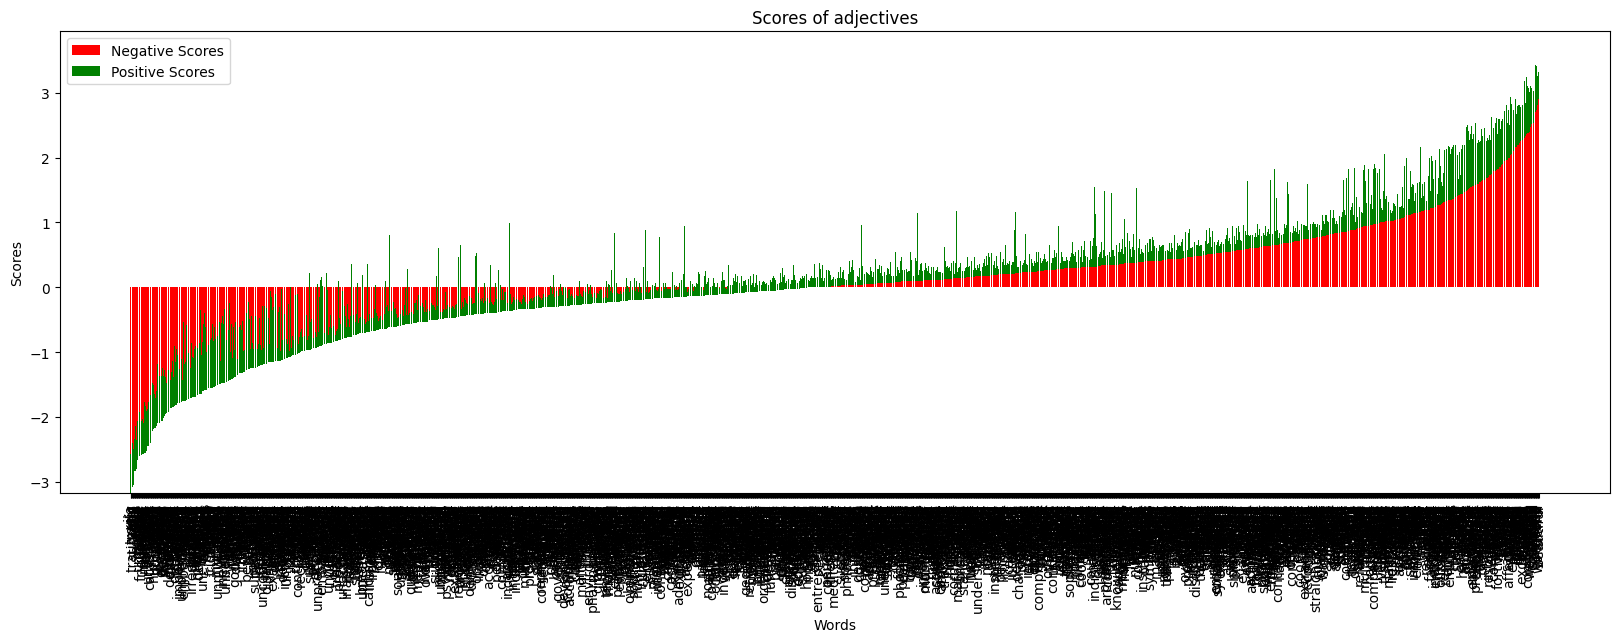

In [14]:
# plotting a graph for words in adjectives file
plt.figure(figsize=(20, 6))
plt.bar(x_axis, negative_scores, color='red', label='Negative Scores')
plt.bar(x_axis, positive_scores, color='green', bottom=negative_scores, label='Positive Scores')
plt.xticks(rotation=90)
plt.title('Scores of adjectives')
plt.xlabel('Words')
plt.ylabel('Scores')
plt.legend()
plt.show()

In [15]:
# Adding all the values to the lexicon_values variable which is a list
lexicon_values = []
xz = {}
for i in all_lexicon_files:
    z = read_lexicons_files('subreddits/'+i)
    xz[i] = len(z)
    lexicon_values.append(z)

In [16]:
names = list(xz.keys())
values = list(xz.values())

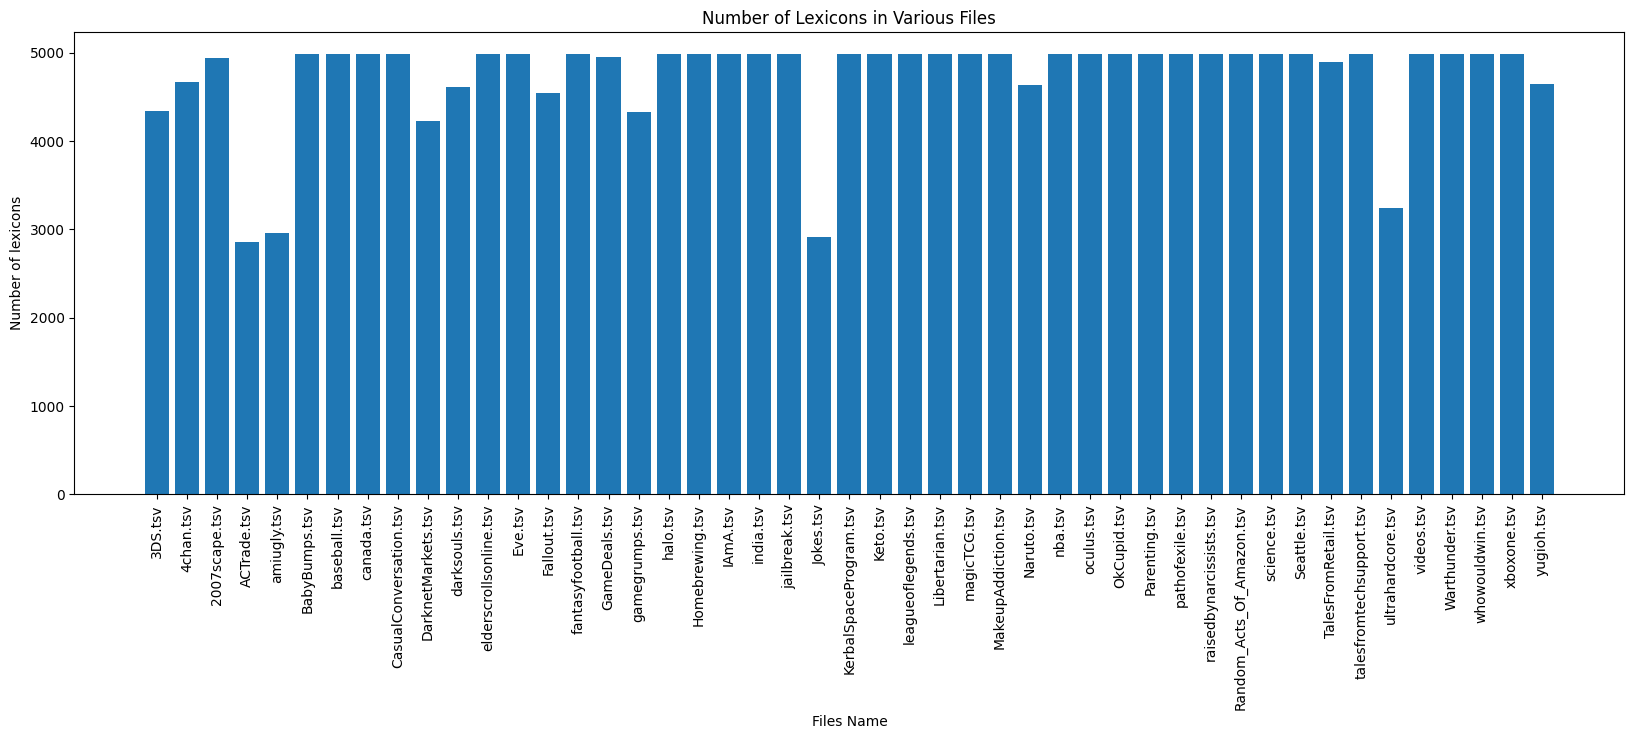

In [17]:
plt.figure(figsize=(20, 6))
plt.bar(names, values)
plt.xticks(rotation=90)
# for i, v in enumerate(values):
#     plt.annotate(str(v), xy=(i, v), ha='center', va='bottom',rotation=90)
plt.xlabel('Files Name')
plt.ylabel('Number of lexicons')
plt.title('Number of Lexicons in Various Files')

# Display the chart
plt.show()

In [18]:
# adding the lexicons of adjectives and lexicons from other files
combined = [adjectives, frequency] + lexicon_values

In [19]:
def get_feature(tweets, combined):
    # divide into list of words
    wordings = tweets.split()
    # Count words in the tweet
    total = len(wordings)
    # Finding the longest word
    longest = max(wordings, key=len)
    
    # set 12 features to the list
    feature_set = [0] * 12

    for i, lex_dict in enumerate(combined[:9]):
        score = 0
        for word in wordings:
            sentiment_dict = lex_dict.get(word, {'-ve': 0, '+ve': 0})
            score += sentiment_dict['-ve'] + sentiment_dict['+ve']
        feature_set[i] = score

        
    # log of the word count for the tweet
    if total > 0:
        feature_set[9] = math.log(total)
    else:
        feature_set[9] = 0

    
    # log of length of longest word
    if longest:
        feature_set[10] = math.log(len(longest))
    else:
        feature_set[10] = 0

    
    # Count of words that have 5 characters or more
    long_word_count = 0
    for word in wordings:
        if len(word) >= 5:
            long_word_count += 1

    # log of count of long words
    if long_word_count > 0:
        feature_set[11] = math.log(long_word_count)
    else:
        feature_set[11] = 0

    
    return feature_set

In [20]:
train_features = [get_feature(tweet, combined) for tweet in train_tweets]
validation_features = [get_feature(tweet, combined) for tweet in val_tweets]
testing_features = [get_feature(tweet, combined) for tweet in test_tweets]

In [21]:
# making as a input using PyTorch for training set
dtype = torch.float32
label_dtype = torch.float32 
X_train = tt(train_features, dtype=dtype)
y_train = tt(list(map(int, train_labels)), dtype=label_dtype).unsqueeze(1)

# making as a input using PyTorch for validation set
X_val = tt(validation_features, dtype=dtype)
y_val = tt(list(map(int, val_labels)), dtype=label_dtype).unsqueeze(1)

# making as a input using PyTorch for test set
X_test = tt(testing_features, dtype=dtype)
y_test = tt(list(map(int, test_labels)), dtype=label_dtype).unsqueeze(1)


In [22]:
class LogisticRegressionDef(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionDef, self).__init__()
        self.linear = nn.Linear(input_size, 1)
#         using sigmoid function from torch library
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        nex = self.linear(x)
        nex = self.sigmoid(nex)
        return nex

    def train(self, X_train, y_train, lr=0.01, epochs=100):
        optimizer = optim.SGD(self.parameters(), lr=lr)
        loss_fn = nn.BCELoss()

        for i in range(epochs):
            y_pred = self(X_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    def predict(self, X):
        with torch.no_grad():
            y_predict = self(X)
            y_predict = (y_predict >= 0.5).float()
        return y_predict

    def evaluate(self, X, y):
        y_predict = self.predict(X)
        find_accuracy = accuracy_score(y, y_predict)
        find_f1 = f1_score(y, y_predict, average='weighted')
        return find_accuracy, find_f1


In [23]:
# creating the object for the class
lr1 = LogisticRegressionDef(12)
# calling the train method
lr1.train(X_train, y_train,lr=0.01, epochs=200)
# getting the accuracy and f1-score for the test sets
accuracy, f1_score = lr1.evaluate(X_test, y_test)
print("Accuracy : ",accuracy)
print("F1 Score : ",f1_score)


Accuracy :  0.48363725170954086
F1 Score :  0.31582110771558486
